# Tutorial

First, you need to install `Photochem` on your computer. Instructions are on the Photochem [README.md](https://github.com/Nicholaswogan/Photochem/blob/main/README.md). Then you can import it.

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from Photochem import Atmosphere, zahnle_earth

Start by initializing an `Atmosphere`. This requires several input files. Here, we use settings for the modern Earth atmosphere.

In [8]:
# Reactions
reaction_file = zahnle_earth 
# Various settings and boundary conditions
settings_file = "../../templates/ModernEarth/settings_ModernEarth.yaml" 
# Star
star_file = "../../templates/ModernEarth/Sun_now.txt" 
# Initial conditions and eddy diffusion and temperature profile
atmosphere_file = "../../templates/ModernEarth/atmosphere_ModernEarth.txt"

pc = Atmosphere(reaction_file,\
                settings_file,\
                star_file,\
                atmosphere_file)

## Integrating to photochemical equilibirum

The first thing many people will want to do is integrate the atmosphere forward in time, until a state of photochemical equilibrium is reached. The function `pc.photochemical_equilibrium()`, integrates the atmosphere for `pc.var.equilibirum_time` seconds, and assumes equilbrium is reached once it reaches that time. The initial conditions are `pc.var.usol_init`, an array of mixing ratios.

In [10]:
success = pc.photochemical_equilibrium()

In [11]:
pc.var.equilibrium_time = 1e14 # Change equilbirium time and integrate
success = pc.photochemical_equilibrium()

`pc.photochemical_equilibrium()` does all integration steps in a single call to the compiled code. This means you can not stop with the program running with `CTRL-C`. You can alternatively do everything one step at a time.

In [14]:
pc.initialize_stepper(pc.var.usol_init) 
tn = 0
while tn < 1e17:
    tn = pc.step()
pc.destroy_stepper()

In Either case, we can look at the solution with `pc.mole_fraction_dict()`

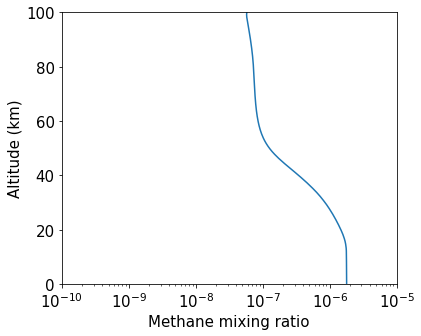

In [26]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[6,5])
sol = pc.mole_fraction_dict()
ax.plot(sol['CH4'],sol['alt'])
ax.set_xscale('log')
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Methane mixing ratio')
ax.set_xlim(1e-10,1e-5)
ax.set_ylim(0,100)
plt.show()

Currently, the boundary condition for CH$_4$ is fixed mixing ratio. Below I change it to a flux boundary condition, and integrate to a new equilibrium, plotting the new methane profile every few steps.

In [24]:
pc.set_lower_bc('CH4',bc_type='flux',flux=1e9)

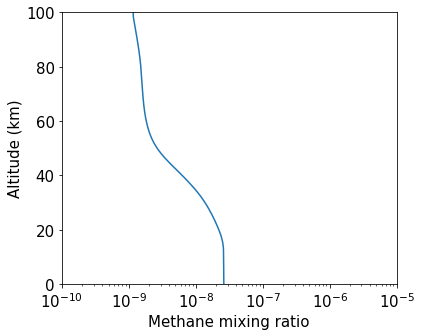

In [28]:
pc.initialize_stepper(pc.var.usol_init) 
tn = 0
while tn < 1e17:
    clear_output(wait=True)
    plt.rcParams.update({'font.size': 15})
    fig,ax = plt.subplots(1,1,figsize=[6,5])
    sol = pc.mole_fraction_dict()
    ax.plot(sol['CH4'],sol['alt'])
    ax.set_xscale('log')
    ax.set_ylabel('Altitude (km)')
    ax.set_xlabel('Methane mixing ratio')
    ax.set_xlim(1e-10,1e-5)
    ax.set_ylim(0,100)
    plt.show()
    for i in range(10):
        tn = pc.step()
pc.destroy_stepper()

We can compute the fluxes of gases into and out of the upper and lower boundary of the model to maintain chemical equilibrium.

In [36]:
surf, top = pc.gas_fluxes() # all in (molecules/cm2/s)
print(surf['CH4'])
print(top['H2'],top['H']) # hydrogen escape

1000000133.7301139
3530195.070635995 80981413.83923405


We can also confirm chemical equilbirum by computing redox conservation, or conservation of some atom

In [34]:
# These all should be << 1 at equilibrium
print(pc.redox_conservation())
print(pc.atom_conservation('C').factor)
print(pc.atom_conservation('S').factor)

3.1153016499410575e-09
2.7118846732061236e-10
6.522862807564113e-11


## Production and Loss of a species

We can analyze the production and loss of species like this

In [60]:
pl = pc.production_and_loss('CH4',pc.wrk.usol)
# all reactions that make CH4 sorted by importance. First is most important
print(pl.production_rx)

['H2O2 + CH3 => CH4 + HO2', 'CH3 + H + M => CH4 + M', 'CH3 + OH => CH4 + O', 'CH3 + H2S => HS + CH4', 'CH3 + H2 => CH4 + H', 'CH3 + HNO => CH4 + NO', 'CH3CHO + hv => CH4 + CO', 'CH3 + H2O => CH4 + OH', 'HS + CH3 => S + CH4', 'CH3 + H2CO => CH4 + HCO', 'CH3 + HCO => CH4 + CO', 'CH3OH + CH3 => CH4 + CH3O', 'CH3 + CH3OH => H2COH + CH4', 'CH3CN + OH => CH4 + NCO', 'NH + CH3 => N + CH4', 'CH3O2 + H => CH4 + O2', 'CH3CO + CH3 => CH4 + CH2CO', 'CH3 + C2H5 => C2H4 + CH4', 'H2CN + CH3 => HCN + CH4', 'CH3 + CH3 => 1CH2 + CH4', 'CH3 + CH3 => CH2 + CH4', 'CH3 + C2H6 => C2H5 + CH4', 'HCl + CH3 => Cl + CH4', 'HCN + CH3 => CN + CH4', 'HCS + CH3 => CS + CH4', 'CH3 + C2H4 => C2H3 + CH4', 'N2H3 + CH3 => N2H2 + CH4', 'CH3 + C2H3 => C2H2 + CH4', 'NH3 + CH3 => NH2 + CH4', 'N2H4 + CH3 => N2H3 + CH4', 'CH3 + OH => O1D + CH4', 'H2COH + H => O1D + CH4', 'NH + CH3 => N2D + CH4', 'C2H2 + CH3 => C2H + CH4', 'C2H + CH3 => C2 + CH4', 'C2H4 + H => CH + CH4', 'H2CN + H2 => N2D + CH4']


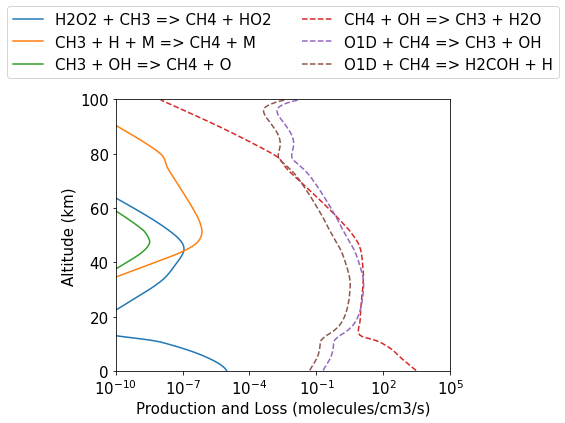

In [63]:
sol = pc.mole_fraction_dict()

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[6,5])

for i in range(3):
    ax.plot(pl.production[:,i],sol['alt'],label=pl.production_rx[i])
    
for i in range(3):
    ax.plot(pl.loss[:,i],sol['alt'],'--',label=pl.loss_rx[i])

ax.set_xscale('log')
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Production and Loss (molecules/cm3/s)')
ax.set_xlim(1e-10,1e5)
ax.set_ylim(0,100)
ax.legend(ncol=2,bbox_to_anchor=(0.5,1.05),loc='lower center')
plt.show()

Chemical production and loss are matched mostly by surface fluxes. This does not include chemical rainout (in rain), which explains why they are slightly different.

In [64]:
net = np.sum(pl.integrated_production) - np.sum(pl.integrated_loss)
print(net)
surf, top = pc.gas_fluxes()
print(surf['CH4'])

-999955134.2371856
1000000133.7301139


## Evolving Atmospheres over time
In the previous sections, we were looking at photochemical equilibrium atmospheres, but we can also evolve atmospheres over time with `pc.evolve`. This function saves all model output to a binary file.

Our model experiment will be to compute the evolution of the atmosphere if we turned off all biogenic gas fluxes to the atmosphere.

In [65]:
pc.set_lower_bc('CH4',bc_type='flux',flux=0)
pc.set_lower_bc('O2',bc_type='flux',flux=0)
pc.set_lower_bc('H2',bc_type='flux',flux=1e10)
pc.set_lower_bc('CO',bc_type='flux',flux=1e9)
pc.set_lower_bc('N2O',bc_type='flux',flux=0)

In [66]:
t_start = 0.0
teval = np.logspace(5,15,100)
success = pc.evolve('outfile.dat',t_start, pc.var.usol_init, teval)

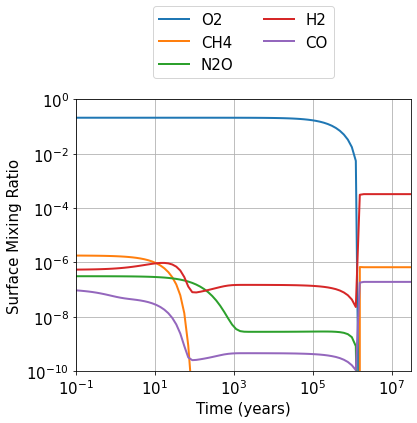

In [79]:
from Photochem.io import read_evolve_output, reformat_output_dict

out = read_evolve_output('outfile.dat')
sol = reformat_output_dict(out)

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[6,5])
yr = 365*24*60*60
species = ['O2','CH4','N2O','H2','CO']
for i,sp, in enumerate(species):
    ax.plot(sol['time']/yr,sol[sp][0,:],label=sp,lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-10,1)
ax.set_xlim(1e-1,3e7)
ax.set_ylabel('Surface Mixing Ratio')
ax.set_xlabel('Time (years)')
ax.legend(ncol=2,bbox_to_anchor=(0.5,1.05),loc='lower center')
ax.grid()
plt.show()